# Initialise

In [2]:
#! /usr/bin/env python

'''
Trains 7D QuaLiKiz-NN with a single output (efeETG_GB)
'''

from __future__ import print_function

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras import backend as K
import pandas
import numpy
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from copy import deepcopy
from keras.models import load_model

Using TensorFlow backend.


In [3]:
# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])

# Define neural network parameters
batch_size = 10
#num_classes = 1
epochs = 100

# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("../unstable_training_gen3_7D_nions0_flat_filter8.h5")
target_df = store['/output/efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']


In [4]:
# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a copy of joined_dataFrame for late use
joined_dataFrame_original = deepcopy(joined_dataFrame)

# Normalize data by standard deviation and mean-centering the data
joined_dataFrame['efeETG_GB'] = (joined_dataFrame['efeETG_GB'] - joined_dataFrame['efeETG_GB'].mean()) / joined_dataFrame['efeETG_GB'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean()) / joined_dataFrame['Ati'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean()) / joined_dataFrame['Ate'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean()) / joined_dataFrame['An'].std()
joined_dataFrame['q'] = (joined_dataFrame['q'] - joined_dataFrame['q'].mean()) / joined_dataFrame['q'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean()) / joined_dataFrame['smag'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean()) / joined_dataFrame['x'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean()) / joined_dataFrame['Ti_Te'].std()

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Creates a pandas dataframe for the inputs
shuffled_clean_input_df = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df.iloc[:int(
    numpy.round(len(shuffled_clean_input_df)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df.iloc[int(
    numpy.round(len(shuffled_clean_input_df)*0.9)):]

# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()

#### DEBUGGING

In [5]:
joined_dataFrame.describe(include='all')

,efeETG_GB,Ati,Ate,An,q,smag,x,Ti_Te
count,639328.000000,6.393280e+05,6.393280e+05,6.393280e+05,6.393280e+05,6.393280e+05,6.393280e+05,6.393280e+05
mean,0.000012,1.633424e-12,-6.496300e-13,-4.409594e-14,3.983713e-14,-8.762553e-14,2.687112e-14,5.456717e-14
std,1.000109,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.136274,-1.848237e+00,-2.151511e+00,-4.175202e+00,-8.733971e-01,-1.264253e+00,-1.375717e+00,-1.667450e+00
25%,-0.802138,-6.585430e-01,-6.647545e-01,-6.345777e-01,-6.748652e-01,-3.148231e-01,-9.568879e-01,-9.268335e-01
50%,-0.302426,-1.486741e-01,-1.691691e-01,-4.447369e-02,-4.385177e-01,-5.588771e-02,-1.192290e-01,-6.771858e-02
75%,0.557581,6.161291e-01,4.916113e-01,5.456303e-01,1.523511e-01,4.619831e-01,7.184299e-01,4.210880e-01
max,3.962243,2.910539e+00,1.813172e+00,2.315942e+00,2.515826e+00,3.914455e+00,1.765503e+00,1.665323e+00


In [6]:
joined_dataFrame_original.describe(include='all')

,efeETG_GB,Ati,Ate,An,q,smag,x,Ti_Te
count,639328.000000,6.393280e+05,639328.000000,639328.000000,639328.000000,639328.000000,639328.000000,639328.000000
mean,26.055342,5.437389e+00,8.512028,2.075366,4.355394,0.464751,0.484161,1.375718
std,22.916607,2.941933e+00,3.026724,1.694616,4.231058,1.158590,0.286513,0.675113
min,0.015788,1.000000e-14,2.000000,-5.000000,0.660000,-1.000000,0.090000,0.250000
25%,7.673069,3.500000e+00,6.500000,1.000000,1.500000,0.100000,0.210000,0.750000
50%,19.124760,5.000000e+00,8.000000,2.000000,2.500000,0.400000,0.450000,1.330000
75%,38.833210,7.250000e+00,10.000000,3.000000,5.000000,1.000000,0.690000,1.660000
max,116.856499,1.400000e+01,14.000000,6.000000,15.000000,5.000000,0.990000,2.500000


# Load Model

In [7]:
new_model = load_model('../Saved-Networks/2018-07-16_7D_Run0050d.h5', custom_objects={'rmse': rmse})

#### Model information

In [8]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________


In [9]:
new_model.get_weights()

[array([[-2.87334411e-03,  2.41862200e-02, -4.12066132e-02,
         -1.34515027e-02,  9.28834919e-03,  1.93074974e-03,
         -1.37387365e-02,  4.32844367e-03, -5.89680718e-03,
          2.03450094e-03, -3.67641784e-02, -1.36629390e-02,
          3.24408151e-03, -1.61009077e-02,  1.55328093e-02,
         -5.37062017e-03,  2.79186517e-02,  1.23187387e-02,
          5.63374674e-03,  1.52084474e-02,  5.09614870e-03,
          2.81141233e-02,  8.71234760e-03,  7.75729641e-02,
          2.03094129e-02, -3.85158360e-02,  1.47108687e-02,
         -7.39949122e-02, -5.51870326e-03,  3.68888886e-03],
        [ 1.64472997e-01,  1.06675661e+00,  4.09337372e-01,
          8.65022659e-01,  1.29730806e-01, -7.61756837e-01,
         -9.31763232e-01,  1.19161308e+00,  1.50285649e+00,
         -7.73032486e-01,  6.38422847e-01, -6.03104711e-01,
          6.45129800e-01,  1.58113435e-01, -2.42174134e-01,
         -8.46612215e-01,  3.21146280e-01,  1.58368856e-01,
          1.67071044e-01,  1.47525787e+

In [10]:
new_model.optimizer

# Predictions (Global)

"Global" in this sense means that I've fed model.predict() with all the possible parameters. This gives a good overview of the overall performance of the network. This can be useful to spot large-scale phenomena like network overfitting but is not so great at looking at say individual data slices. This is done later.

***Nota Bene: all data here is NORMALIZED at this stage.***

In [11]:
y_test_np_array = y_test.values
print(y_test_np_array)

[-0.96080492 -0.77065543 -0.91422564 ... -0.28796506 -0.21396804
  0.34859219]


In [12]:
x_test_np_array = x_test.values
print(x_test_np_array)

[[ 0.61612912  1.81317227 -0.04447369 ...  0.20304767 -0.95688786
  -1.66744973]
 [-0.65854296  0.49161133 -0.63457771 ...  0.89354209  0.29960042
  -0.55652537]
 [ 0.10626029  1.81317227  0.54563033 ...  3.91445512  1.76550348
  -0.55652537]
 ...
 [-0.65854296 -1.16033984  1.13573434 ...  0.46198309  1.24196657
   0.42108802]
 [-0.40360854 -0.16916913 -0.04447369 ...  0.46198309 -1.37571725
  -0.55652537]
 [-0.14867413  0.49161133 -0.63457771 ... -0.05588771 -0.95688786
  -1.29714161]]


In [13]:
predictions_global = new_model.predict(x_test_np_array, batch_size = 10, verbose=0)
print(type(predictions_global))

predictions_global = predictions_global.flatten()
print(predictions_global.shape)
print(type(predictions_global))

<class 'numpy.ndarray'>
(63933,)
<class 'numpy.ndarray'>


### Predictions (Global) review - Normalized

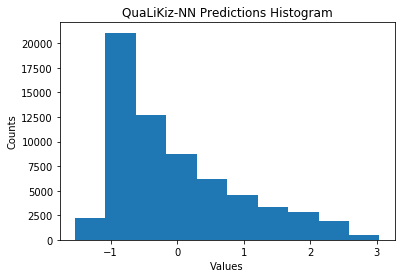

In [14]:
plt.hist(predictions_global)
plt.title('QuaLiKiz-NN Predictions Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()

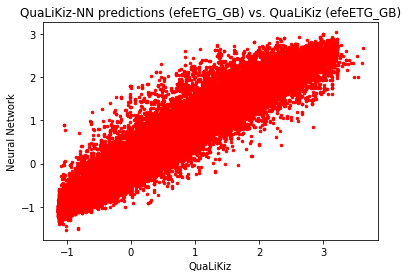

In [15]:
plt.plot(y_test_np_array, predictions_global, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.title('QuaLiKiz-NN predictions (efeETG_GB) vs. QuaLiKiz (efeETG_GB)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.show()

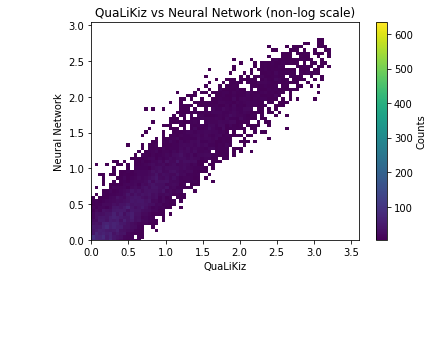

In [16]:
plt.hist2d(y_test_np_array, predictions_global, bins=100, cmin=5)
# plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()

C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


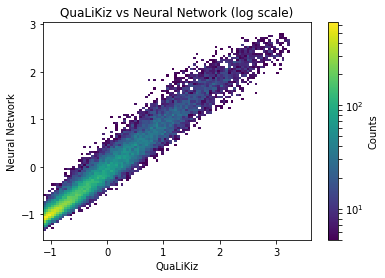

In [17]:
plt.hist2d(y_test_np_array, predictions_global, bins=100, norm=LogNorm(), cmin=5)
# plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
# plt.ylim(0)
# plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.show()

### Sigmas (Normalized)

These plots show how spread out the datapoints in the earlier Neural Network vs. QuaLiKiz plots are.

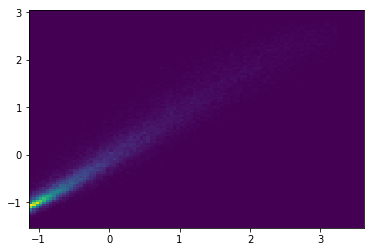

In [18]:
h = plt.hist2d(y_test_np_array, predictions_global,bins = 100)

In [19]:
sigmas = []
Qualikiz = y_test_np_array
for i in range(len(h[0])):
    sigmas.append(numpy.std(h[0][i] / numpy.max(h[0][i])))

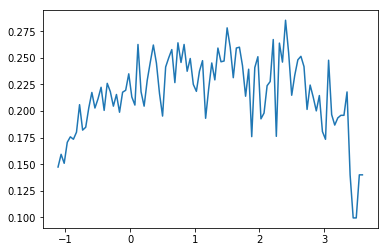

In [20]:
plt.plot((numpy.array(h[1][1:]) + numpy.array(h[1][:-1]))/2.,sigmas)
plt.show()

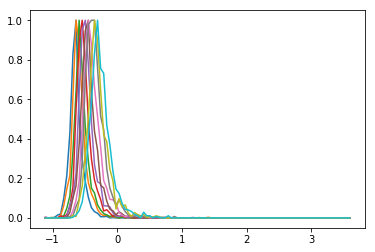

In [21]:
for i in range(10):
    plt.plot((h[1][1:] + h[1][:-1])/2., h[0][i]/numpy.max(h[0][i]) )

### Exploring the spread of the predictions vs. original QuaLiKiz inputs

Here we explore the difference between our neural network predictions (of efeETG_GB) vs. the values of the original dataset (unstable_training_gen2_7D_nions0_flat_filter7.h5). The two graphs merely show different dot sizes.

In a perfect case we would have a single line at y = 0 signaling zero disagreement.

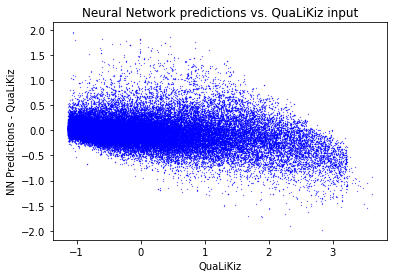

In [22]:
plt.plot(y_test_np_array, predictions_global - y_test_np_array, 'b.', ms = 0.5)
plt.title('Neural Network predictions vs. QuaLiKiz input')
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
plt.show()

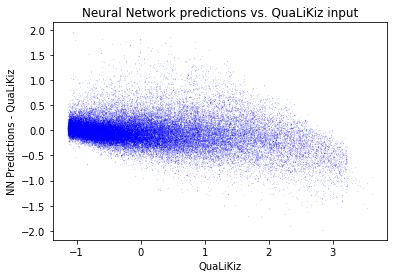

In [23]:
plt.plot(y_test_np_array, predictions_global - y_test_np_array, 'b.', ms = 0.1)
plt.title('Neural Network predictions vs. QuaLiKiz input')
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
plt.show()

### Predictions (Global) review - De-Normalized

In [24]:
predictions_global_deNormalized = (predictions_global * joined_dataFrame_original['efeETG_GB'].std()) + joined_dataFrame_original['efeETG_GB'].mean()

In [25]:
y_test_deNormalized = (y_test * joined_dataFrame_original['efeETG_GB'].std()) + joined_dataFrame_original['efeETG_GB'].mean()

In [26]:
y_test_deNormalized_np_array = y_test_deNormalized.values

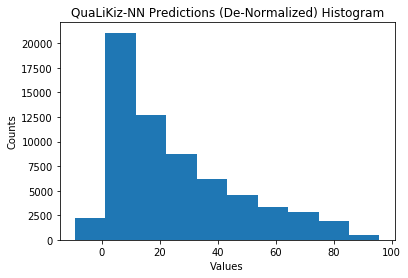

In [27]:
plt.hist(predictions_global_deNormalized)
plt.title('QuaLiKiz-NN Predictions (De-Normalized) Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()

In [28]:
print(predictions_global.shape)

(63933,)


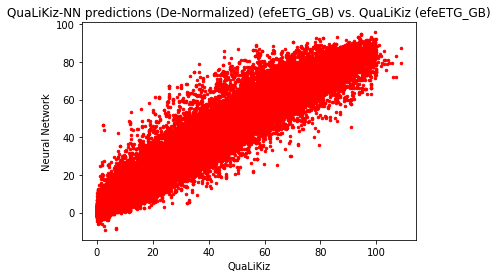

In [29]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.title('QuaLiKiz-NN predictions (De-Normalized) (efeETG_GB) vs. QuaLiKiz (efeETG_GB)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.show()

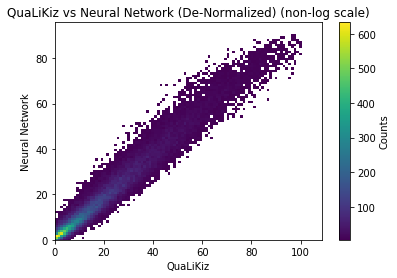

In [30]:
plt.hist2d(y_test_deNormalized_np_array, predictions_global_deNormalized, bins=100, cmin=5)
# plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (De-Normalized) (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()

### Sigmas (De-Normalized)

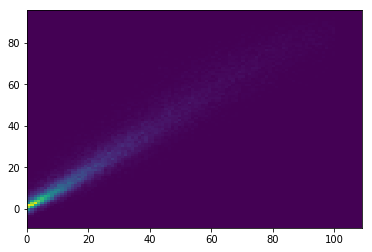

In [31]:
h_deNormalized = plt.hist2d(y_test_deNormalized_np_array, predictions_global_deNormalized,bins = 100)

In [32]:
sigmas_deNormalized = []
Qualikiz_deNormalized = y_test_deNormalized_np_array
for i in range(len(h[0])):
    sigmas_deNormalized.append(numpy.std(h_deNormalized[0][i] / numpy.max(h_deNormalized[0][i])))

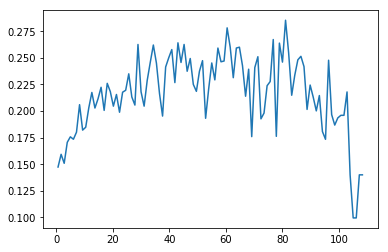

In [33]:
plt.plot((numpy.array(h_deNormalized[1][1:]) + numpy.array(h_deNormalized[1][:-1]))/2.,sigmas_deNormalized)
plt.show()

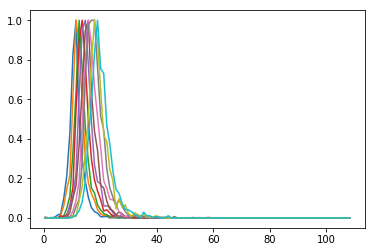

In [34]:
for i in range(10):
    plt.plot((h_deNormalized[1][1:] + h_deNormalized[1][:-1])/2., h_deNormalized[0][i]/numpy.max(h_deNormalized[0][i]) )

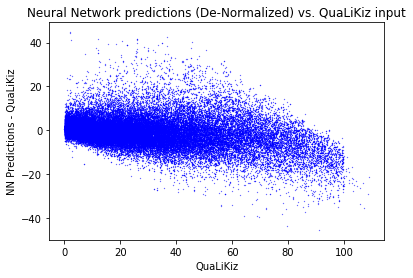

In [35]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized - y_test_deNormalized_np_array, 'b.', ms = 0.5)
plt.title('Neural Network predictions (De-Normalized) vs. QuaLiKiz input')
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
plt.show()

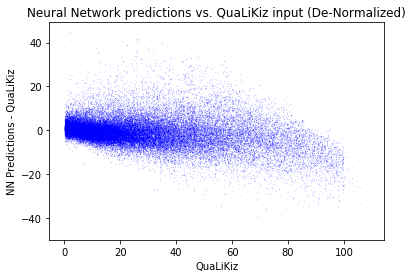

In [36]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized - y_test_deNormalized_np_array, 'b.', ms = 0.1)
plt.title('Neural Network predictions vs. QuaLiKiz input (De-Normalized)')
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
plt.show()

# Predictions (single Data Slice)

### Predictions - Initialise table to feed predictions

In [37]:
# table (Original values from input file unstable_training_gen2_7D_nions0_flat_filter7.h5)
# Hard-coded variables for the data slice

table = numpy.zeros((200,7))

table[:,0] = 5.75    # Ati
table[:,1] = numpy.linspace(2,14,200)   # Ate
table[:,2] = 3       # An
table[:,3] = 3       # qx
table[:,4] = 0.7     # smag
table[:,5] = 0.45    # x
table[:,6] = 1.33    # Ti_Te

table

array([[ 5.75      ,  2.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.06030151,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.12060302,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       ...,
       [ 5.75      , 13.87939698,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 13.93969849,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 14.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ]])

In [38]:
# Normalized table (inputs for model.predict())
table_normalized = numpy.zeros((200,7))

DataSlice_Ati = 5.75
DataSlice_Ate = numpy.linspace(2,14,200)
DataSlice_An = 3
DataSlice_q = 3
DataSlice_smag = 0.7
DataSlice_x = 0.45
DataSlice_Ti_Te = 1.33

# Normalize data by standard deviation and mean-centering the data
table_normalized[:,0] = (DataSlice_Ati - joined_dataFrame_original['Ati'].mean()) / joined_dataFrame_original['Ati'].std()
table_normalized[:,1] = (DataSlice_Ate - joined_dataFrame_original['Ate'].mean()) / joined_dataFrame_original['Ate'].std()
table_normalized[:,2] = (DataSlice_An - joined_dataFrame_original['An'].mean()) / joined_dataFrame_original['An'].std()
table_normalized[:,3] = (DataSlice_q - joined_dataFrame_original['q'].mean()) / joined_dataFrame_original['q'].std()
table_normalized[:,4] = (DataSlice_smag - joined_dataFrame_original['smag'].mean()) / joined_dataFrame_original['smag'].std()
table_normalized[:,5] = (DataSlice_x - joined_dataFrame_original['x'].mean()) / joined_dataFrame_original['x'].std()
table_normalized[:,6] = (DataSlice_Ti_Te - joined_dataFrame_original['Ti_Te'].mean()) / joined_dataFrame_original['Ti_Te'].std()

In [39]:
table_normalized

array([[ 0.10626029, -2.15151054,  0.54563033, ...,  0.20304769,
        -0.11922898, -0.06771865],
       [ 0.10626029, -2.13158751,  0.54563033, ...,  0.20304769,
        -0.11922898, -0.06771865],
       [ 0.10626029, -2.11166448,  0.54563033, ...,  0.20304769,
        -0.11922898, -0.06771865],
       ...,
       [ 0.10626029,  1.77332621,  0.54563033, ...,  0.20304769,
        -0.11922898, -0.06771865],
       [ 0.10626029,  1.79324924,  0.54563033, ...,  0.20304769,
        -0.11922898, -0.06771865],
       [ 0.10626029,  1.81317227,  0.54563033, ...,  0.20304769,
        -0.11922898, -0.06771865]])

In [40]:
# joined_dataFrame.to_csv('./out_joined_dataFrame.csv', encoding='utf-8')

In [41]:
predictions = new_model.predict(table_normalized, batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))

<class 'numpy.ndarray'>
(200,)
<class 'numpy.ndarray'>


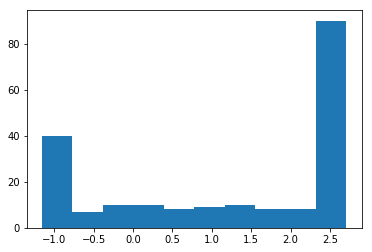

In [42]:
plt.hist(predictions)
plt.show()

# Masks

These are used to rapidly select which parameters to look at (for a given data slice).

#### Ate

In [43]:
Ate_mask1 = joined_dataFrame_original.Ate == 2
Ate_mask2 = joined_dataFrame_original.Ate == 2.75
Ate_mask3 = joined_dataFrame_original.Ate == 3.5
Ate_mask4 = joined_dataFrame_original.Ate == 4.25
Ate_mask5 = joined_dataFrame_original.Ate == 5
Ate_mask6 = joined_dataFrame_original.Ate == 5.75
Ate_mask7 = joined_dataFrame_original.Ate == 6.5
Ate_mask8 = joined_dataFrame_original.Ate == 7.25
Ate_mask9 = joined_dataFrame_original.Ate == 8
Ate_mask10 = joined_dataFrame_original.Ate == 10
Ate_mask11 = joined_dataFrame_original.Ate == 14

Ate_anti_mask1 = joined_dataFrame_original.Ate != 2
Ate_anti_mask2 = joined_dataFrame_original.Ate != 2.75
Ate_anti_mask3 = joined_dataFrame_original.Ate != 3.5
Ate_anti_mask4 = joined_dataFrame_original.Ate != 4.25
Ate_anti_mask5 = joined_dataFrame_original.Ate != 5
Ate_anti_mask6 = joined_dataFrame_original.Ate != 5.75
Ate_anti_mask7 = joined_dataFrame_original.Ate != 6.5
Ate_anti_mask8 = joined_dataFrame_original.Ate != 7.25
Ate_anti_mask9 = joined_dataFrame_original.Ate != 8
Ate_anti_mask10 = joined_dataFrame_original.Ate != 10
Ate_anti_mask11 = joined_dataFrame_original.Ate != 14

#### An

In [44]:
An_mask1 = joined_dataFrame_original.An == -5
An_mask2 = joined_dataFrame_original.An == -3
An_mask3 = joined_dataFrame_original.An == -1
An_mask4 = numpy.array(joined_dataFrame_original.An <= 1.1e-14) * numpy.array(joined_dataFrame_original.An >= 9E-15)
An_mask5 = joined_dataFrame_original.An == 0.5
An_mask6 = joined_dataFrame_original.An == 1.0
An_mask7 = joined_dataFrame_original.An == 1.5
An_mask8 = joined_dataFrame_original.An == 2.0
An_mask9 = joined_dataFrame_original.An == 2.5
An_mask10 = joined_dataFrame_original.An == 3.0
An_mask11 = joined_dataFrame_original.An == 4.0
An_mask12 = joined_dataFrame_original.An == 6.0

An_anti_mask1 = joined_dataFrame_original.An != -5
An_anti_mask2 = joined_dataFrame_original.An != -3
An_anti_mask3 = joined_dataFrame_original.An != -1
An_anti_mask4 = numpy.array(joined_dataFrame_original.An >= 1.1e-14) * numpy.array(joined_dataFrame_original.An <= 9E-15)
An_anti_mask5 = joined_dataFrame_original.An != 0.5
An_anti_mask6 = joined_dataFrame_original.An != 1.0
An_anti_mask7 = joined_dataFrame_original.An != 1.5
An_anti_mask8 = joined_dataFrame_original.An != 2.0
An_anti_mask9 = joined_dataFrame_original.An != 2.5
An_anti_mask10 = joined_dataFrame_original.An != 3.0
An_anti_mask11 = joined_dataFrame_original.An != 4.0
An_anti_mask12 = joined_dataFrame_original.An != 6.0

#### Ati

In [45]:
Ati_mask1 = numpy.array(joined_dataFrame_original.Ati <= 1.1e-14) * numpy.array(joined_dataFrame_original.Ati >= 9E-15)
Ati_mask2 = joined_dataFrame_original.Ati == 2
Ati_mask3 = joined_dataFrame_original.Ati == 2.75
Ati_mask4 = joined_dataFrame_original.Ati == 3.5
Ati_mask5 = joined_dataFrame_original.Ati == 4.25
Ati_mask6 = joined_dataFrame_original.Ati == 5
Ati_mask7 = joined_dataFrame_original.Ati == 5.75
Ati_mask8 = joined_dataFrame_original.Ati == 6.5
Ati_mask9 = joined_dataFrame_original.Ati == 7.25
Ati_mask10 = joined_dataFrame_original.Ati == 8
Ati_mask11 = joined_dataFrame_original.Ati == 10
Ati_mask12 = joined_dataFrame_original.Ati == 14

#### qx

In [46]:
q_mask0 = numpy.array(joined_dataFrame_original.q <= 0.67) * numpy.array(joined_dataFrame_original.q >= 0.65)  #0.66
q_mask1 = joined_dataFrame_original.q == 1.0
q_mask2 = joined_dataFrame_original.q == 1.5
q_mask3 = joined_dataFrame_original.q == 2.0
q_mask4 = joined_dataFrame_original.q == 2.5
q_mask5 = joined_dataFrame_original.q == 3.0
q_mask6 = joined_dataFrame_original.q == 4.0
q_mask7 = joined_dataFrame_original.q == 5.0
q_mask8 = joined_dataFrame_original.q == 10.00
q_mask9 = joined_dataFrame_original.q == 15.00

q_anti_mask0 = numpy.array(joined_dataFrame_original.q >= 0.67) * numpy.array(joined_dataFrame_original.q <= 0.65)  #0.66
q_anti_mask1 = joined_dataFrame_original.q != 1.0
q_anti_mask2 = joined_dataFrame_original.q != 1.5
q_anti_mask3 = joined_dataFrame_original.q != 2.0
q_anti_mask4 = joined_dataFrame_original.q != 2.5
q_anti_mask5 = joined_dataFrame_original.q != 3.0
q_anti_mask6 = joined_dataFrame_original.q != 4.0
q_anti_mask7 = joined_dataFrame_original.q != 5.0
q_anti_mask8 = joined_dataFrame_original.q != 10.00
q_anti_mask9 = joined_dataFrame_original.q != 15.00

#### smag

In [47]:
smag_mask1 = joined_dataFrame_original.smag == -1.0
smag_mask2 = numpy.array(joined_dataFrame_original.smag <= 0.11) * numpy.array(joined_dataFrame_original.smag >= 0.09)   # 0.1
smag_mask3 = numpy.array(joined_dataFrame_original.smag <= 0.41) * numpy.array(joined_dataFrame_original.smag >= 0.39)   # 0.4
smag_mask4 = numpy.array(joined_dataFrame_original.smag <= 0.71) * numpy.array(joined_dataFrame_original.smag >= 0.68)   # 0.7
smag_mask5 = joined_dataFrame_original.smag == 1
smag_mask6 = joined_dataFrame_original.smag == 1.5
smag_mask7 = joined_dataFrame_original.smag == 2.0
smag_mask8 = joined_dataFrame_original.smag == 2.75
smag_mask9 = joined_dataFrame_original.smag == 3.5
smag_mask10 = joined_dataFrame_original.smag == 5.0

smag_anti_mask1 = joined_dataFrame_original.smag != -1.0
smag_anti_mask2 = numpy.array(joined_dataFrame_original.smag >= 0.11) * numpy.array(joined_dataFrame_original.smag <= 0.09)   # 0.1
smag_anti_mask3 = numpy.array(joined_dataFrame_original.smag >= 0.41) * numpy.array(joined_dataFrame_original.smag <= 0.39)   # 0.4
smag_anti_mask4 = numpy.array(joined_dataFrame_original.smag >= 0.71) * numpy.array(joined_dataFrame_original.smag <= 0.68)   # 0.7
smag_anti_mask5 = joined_dataFrame_original.smag != 1
smag_anti_mask6 = joined_dataFrame_original.smag != 1.5
smag_anti_mask7 = joined_dataFrame_original.smag != 2.0
smag_anti_mask8 = joined_dataFrame_original.smag != 2.75
smag_anti_mask9 = joined_dataFrame_original.smag != 3.5
smag_anti_mask10 = joined_dataFrame_original.smag != 5.0

#### x

In [48]:
x_mask1 = numpy.array(joined_dataFrame_original.x <= 0.10) * numpy.array(joined_dataFrame_original.x >= 0.08)   # 0.09
x_mask2 = numpy.array(joined_dataFrame_original.x <= 0.22) * numpy.array(joined_dataFrame_original.x >= 0.20)   # 0.21
x_mask3 = numpy.array(joined_dataFrame_original.x <= 0.34) * numpy.array(joined_dataFrame_original.x >= 0.32)   # 0.33
x_mask4 = numpy.array(joined_dataFrame_original.x <= 0.46) * numpy.array(joined_dataFrame_original.x >= 0.44)   # 0.45
x_mask5 = numpy.array(joined_dataFrame_original.x <= 0.58) * numpy.array(joined_dataFrame_original.x >= 0.56)   # 0.57
x_mask6 = numpy.array(joined_dataFrame_original.x <= 0.70) * numpy.array(joined_dataFrame_original.x >= 0.68)   # 0.69
x_mask7 = numpy.array(joined_dataFrame_original.x <= 0.85) * numpy.array(joined_dataFrame_original.x >= 0.83)   # 0.84
x_mask8 = numpy.array(joined_dataFrame_original.x <= 1.00) * numpy.array(joined_dataFrame_original.x >= 0.98)   # 0.99

x_anti_mask1 = numpy.array(joined_dataFrame_original.x >= 0.10) * numpy.array(joined_dataFrame_original.x <= 0.08)   # 0.09
x_anti_mask2 = numpy.array(joined_dataFrame_original.x >= 0.22) * numpy.array(joined_dataFrame_original.x <= 0.20)   # 0.21
x_anti_mask3 = numpy.array(joined_dataFrame_original.x >= 0.34) * numpy.array(joined_dataFrame_original.x <= 0.32)   # 0.33
x_anti_mask4 = numpy.array(joined_dataFrame_original.x >= 0.46) * numpy.array(joined_dataFrame_original.x <= 0.44)   # 0.45
x_anti_mask5 = numpy.array(joined_dataFrame_original.x >= 0.58) * numpy.array(joined_dataFrame_original.x <= 0.56)   # 0.57
x_anti_mask6 = numpy.array(joined_dataFrame_original.x >= 0.70) * numpy.array(joined_dataFrame_original.x <= 0.68)   # 0.69
x_anti_mask7 = numpy.array(joined_dataFrame_original.x >= 0.85) * numpy.array(joined_dataFrame_original.x <= 0.83)   # 0.84
x_anti_mask8 = numpy.array(joined_dataFrame_original.x >= 1.00) * numpy.array(joined_dataFrame_original.x <= 0.98)   # 0.99

#### Ti_Te

In [49]:
Ti_Te_mask1 = joined_dataFrame_original.Ti_Te == 0.25
Ti_Te_mask2 = joined_dataFrame_original.Ti_Te == 0.5
Ti_Te_mask3 = joined_dataFrame_original.Ti_Te == 0.75
Ti_Te_mask4 = joined_dataFrame_original.Ti_Te == 1
Ti_Te_mask5 = numpy.array(joined_dataFrame_original.Ti_Te <= 1.34) * numpy.array(joined_dataFrame_original.Ti_Te >= 1.32)   # 1.33
Ti_Te_mask6 = numpy.array(joined_dataFrame_original.Ti_Te <= 1.67) * numpy.array(joined_dataFrame_original.Ti_Te >= 1.65)   # 1.66
Ti_Te_mask7 = joined_dataFrame_original.Ti_Te == 2.50

# Plots

In [50]:
'''
{'An': 3,
'Ati': 5.75,
'Ti_Te': 1.33,
'q': 3,
'smag': 0.7,
'x': 0.45}
'''

newDF = joined_dataFrame[An_mask10 & Ati_mask7 & q_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable 
newDF_Mk2 = joined_dataFrame_original[An_mask10 & Ati_mask7 & q_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable 
print(newDF)
print(type(newDF))

print(newDF_Mk2)
print(type(newDF_Mk2))

          efeETG_GB      Ati       Ate       An         q      smag         x  \
30963559  -0.813469  0.10626 -1.408133  0.54563 -0.320344  0.203048 -0.119229   
31366759  -0.557189  0.10626 -1.160340  0.54563 -0.320344  0.203048 -0.119229   
32576359   1.642665  0.10626 -0.416962  0.54563 -0.320344  0.203048 -0.119229   

             Ti_Te  
30963559 -0.067719  
31366759 -0.067719  
32576359 -0.067719  
<class 'pandas.core.frame.DataFrame'>
          efeETG_GB   Ati   Ate   An    q  smag     x  Ti_Te
30963559   7.413384  5.75  4.25  3.0  3.0   0.7  0.45   1.33
31366759  13.286460  5.75  5.00  3.0  3.0   0.7  0.45   1.33
32576359  63.699650  5.75  7.25  3.0  3.0   0.7  0.45   1.33
<class 'pandas.core.frame.DataFrame'>


In [51]:
efeETG_DF = newDF['efeETG_GB']
efeETG_DF_np_array = efeETG_DF.values
print(efeETG_DF_np_array)

Ate_DF = newDF['Ate']
Ate_DF_np_array = Ate_DF.values
print(Ate_DF_np_array)

[-0.81346937 -0.55718902  1.642665  ]
[-1.40813251 -1.16033984 -0.41696181]


In [52]:
efeETG_DF_Mk2 = newDF_Mk2['efeETG_GB']
efeETG_DF_Mk2_np_array = efeETG_DF_Mk2.values
print(efeETG_DF_Mk2_np_array)

Ate_DF_Mk2 = newDF_Mk2['Ate']
Ate_DF_Mk2_np_array = Ate_DF_Mk2.values
print(Ate_DF_Mk2_np_array)

[ 7.413384 13.28646  63.69965 ]
[4.25 5.   7.25]


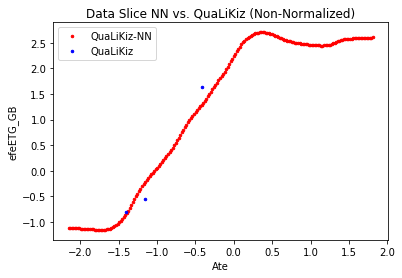

In [53]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table_normalized[:,1], predictions, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.title('Data Slice NN vs. QuaLiKiz (Non-Normalized)')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [54]:
predictions_deNormalized = (predictions * joined_dataFrame_original['efeETG_GB'].std()) + joined_dataFrame_original['efeETG_GB'].mean()
print(predictions_deNormalized.shape)

(200,)


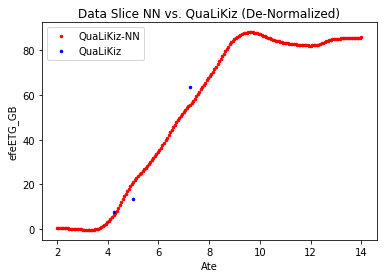

In [55]:
plt.plot(table[:,1], predictions_deNormalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_Mk2_np_array, efeETG_DF_Mk2_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.title('Data Slice NN vs. QuaLiKiz (De-Normalized)')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
# plt.savefig('./2018-07-17_TableTestingNotebook_Mk2/NN_Predictions.png', dpi = 100)
plt.show()